In [1]:
import os, time, errno
import torch, tables
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
os.environ['CUDA_VISIBLE_DEVICES']='1'
savedir = '8x8-convnet'

In [3]:
T = 10 # time buckets

hdf5 = tables.open_file('captures/fei/R1_E3_AMES_200min_200f_14l_rgb.h5','r')
hdf5 = hdf5.root

try:
    dataset = np.load('captures/fei/cache.npy')
except FileNotFoundError:

    data = []
    for i in range(7):
        print('.',end='')
        batch = np.array(hdf5['data'][i*400:(i+1)*400])
        batch = batch.reshape(-1,T,int(batch.shape[1]/T),64,64,6).sum(2).astype(np.float32) # binning
        data.append(batch)
        
    dataset = np.concatenate(data,axis=0)
    dataset = np.moveaxis(dataset,[0,1,2,3,4],[0,1,3,4,2])
    np.save('captures/fei/cache.npy', dataset)

classes = np.array([np.array(itm.decode('utf-8').split('"'))[[1,3]].astype(np.int32)
                    for itm in np.array(hdf5['image_classes'].read())])

# Presented targets

In [4]:
imgs = hdf5["images"][0:100]
y,x = np.where(np.mean(imgs, axis=(0,3))>5)
xleft, xright, ytop, ybot = min(x), max(x), min(y), max(y)

images = hdf5["images"][:,ytop:ybot,xleft:xright]

tiny_images = []
for i in range(len(images)):
    tiny_images.append(cv2.resize(images[i],(64,64)))
images = np.stack(tiny_images)

# Model

In [5]:
class Block(torch.nn.Module):
    def __init__(self, filters):
        super(Block, self).__init__()
        
        self.block = torch.nn.Sequential(
            torch.nn.Conv2d(filters, filters, 3, padding=1, bias=False),
            torch.nn.BatchNorm2d(filters), torch.nn.ReLU(),
            torch.nn.Conv2d(filters, filters, 3, padding=1, bias=False),
            torch.nn.BatchNorm2d(filters))
        
    def forward(self, x):
        return F.relu(x + self.block(x))
    
class ConvNet(torch.nn.Module):
    def __init__(self, filters=128):
        super(ConvNet, self).__init__()
        self.filters = filters
        
        self.conv_in = torch.nn.Conv2d(10*6, filters, 9, padding=4, stride=1, bias=False)
        
        self.resnet = torch.nn.ModuleList()
        for i in range(101): self.resnet.append(Block(filters))
            
        self.conv_out =  torch.nn.ConvTranspose2d(self.filters, 1, 8, stride=8, bias=True)
        self.bias = torch.nn.Parameter(torch.Tensor(64,64))
        
        for name, parm in self.named_parameters():
            if name.endswith('weight'): torch.nn.init.normal_(parm, 0, .01)
            if name.endswith('bias'): torch.nn.init.constant_(parm, 0.0)
    
    def forward(self, x):
        x = x.view(-1,10*6,64,64)[:,:,::8,::8].contiguous()
        zx = F.relu(self.conv_in(x))
        for layer in self.resnet: zx = layer(zx)
        return torch.sigmoid(self.conv_out(zx).squeeze() + self.bias[None,:,:])

# Fit

In [6]:
data = torch.tensor(dataset)/30. # scaling
targets = torch.tensor(images).float().mean(3)/255.

In [7]:
train_data = data[[i for i in range(2800) if (i+1)%5 != 0]]
val_data = data[slice(4,2800,10)]
test_data = data[slice(9,2800,10)]

train_targets = targets[[i for i in range(2800) if (i+1)%5 != 0]]
val_targets = targets[slice(4,2800,10)]
test_targets = targets[slice(9,2800,10)]

In [8]:
batch_size = 50

model = ConvNet().cuda()
count = sum([np.prod(parm.shape) for parm in model.parameters() if parm.requires_grad])
print('Initialized a graph with {} parameters'.format(count))

train_history = []
val_history = []

model.eval()
loss = 0.
for i in np.random.permutation(len(val_data)//batch_size):
    start, end = i*batch_size, (i+1)*batch_size
    x,z = val_data[start:end].cuda(), val_targets[start:end].cuda()
    loss += ((model(x).detach() - z)**2).sum(1).mean()
val_history.append(loss/(len(val_data)//batch_size))
print('Initial Loss: {:2f}'.format(val_history[-1]))

Initialized a graph with 30472193 parameters
Initial Loss: 4.065684


In [9]:
batch_size = 50
optimizer = torch.optim.Adam(model.parameters(), lr=.0003)

try:
    print('epoch\ttrain loss\ttest loss\ttime\t\tutime')
    t0 = time.time()
    for epoch in range(500):
        model.train()
        loss_train = 0
        for i in np.random.permutation(len(train_data)//batch_size):
            start, end = i*batch_size, (i+1)*batch_size
            x,z = train_data[start:end].cuda(), train_targets[start:end].cuda()
            loss = ((model(x) - z)**2).sum(1).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.detach()
        train_history.append(loss_train/(len(train_data)//batch_size))

        if epoch % 1 == 0:
            t1 = time.time()
            model.eval()
            loss = 0.
            for i in range(len(val_data)//batch_size):
                start, end = i*batch_size, (i+1)*batch_size
                x,z = val_data[start:end].cuda(), val_targets[start:end].cuda()
                loss += ((model(x).detach() - z)**2).sum(1).mean()
            val_history.append(loss/(len(val_data)//batch_size))
            print('{:d}\t{:2f}\t{:2f}\t{:2f}\t{:2f}'.format(epoch,train_history[-1],val_history[-1],time.time()-t0, time.time()-t1))
            t0 = time.time()
            
except KeyboardInterrupt:
    print('Graceful Exit')
else:
    print('Finished')

epoch	train loss	test loss	time		utime
0	2.510805	3.854654	9.780442	0.328743
1	1.532952	2.228081	10.435509	0.351050
2	1.331082	2.019372	10.629572	0.337649
3	1.241134	2.539794	10.641076	0.347011
4	1.142779	1.525375	9.224647	0.207904
5	1.083699	2.976828	8.296988	0.207880
6	1.043358	1.333596	8.344779	0.206682
7	1.002727	1.593941	8.402763	0.209785
8	0.978849	1.338383	8.368725	0.206096
9	0.904575	1.431983	8.349205	0.207475
10	0.863924	1.679649	8.419223	0.209707
11	0.887721	1.950099	8.369853	0.212906
12	0.820011	1.569039	8.371638	0.208922
13	0.763274	1.470659	8.361411	0.207704
14	0.749855	1.543422	8.391479	0.208113
15	0.704753	1.322669	8.408146	0.208387
16	0.690330	1.492212	8.391735	0.207703
17	0.663857	1.511248	8.406882	0.207699
18	0.702749	1.919475	8.396781	0.207744
19	0.637772	1.592972	8.414046	0.210114
20	0.613736	1.563691	8.729741	0.210803
21	0.588742	1.630657	9.170308	0.344346
22	0.571994	1.494974	10.770648	0.338400
23	0.564534	1.596856	10.789265	0.343857
24	0.572019	1.521083	9.719687	

208	0.143109	1.355132	8.504073	0.210781
209	0.136888	1.419380	8.501683	0.208714
210	0.121563	1.408272	8.537303	0.208289
211	0.103467	1.406560	8.476532	0.209429
212	0.082688	1.348148	8.536937	0.210675
213	0.069181	1.359477	8.490357	0.210789
214	0.061680	1.308803	8.542294	0.209964
215	0.057669	1.326197	8.522948	0.207263
216	0.055093	1.319523	8.510621	0.211287
217	0.053677	1.339221	8.480264	0.210047
218	0.052337	1.311648	8.514448	0.210340
219	0.050951	1.334140	8.494380	0.209883
220	0.050017	1.339849	8.554598	0.212131
221	0.049294	1.307799	8.495266	0.210389
222	0.048960	1.314141	8.513207	0.209339
223	0.048474	1.396920	8.505265	0.208990
224	0.048058	1.340228	8.524718	0.207381
225	0.047985	1.342134	8.491217	0.208600
226	0.048169	1.341187	8.467168	0.207208
227	0.049584	1.335326	8.520760	0.210367
228	0.051912	1.338626	8.528460	0.210704
229	0.056406	1.332342	8.531473	0.210539
230	0.060654	1.322704	8.504265	0.210043
231	0.063453	1.345620	8.489631	0.210375
232	0.064258	1.342318	8.499283	0.206618


413	0.121553	1.351526	8.487412	0.210365
414	0.100644	1.304056	8.511584	0.213453
415	0.068044	1.296132	8.499745	0.211487
416	0.045187	1.307249	8.565000	0.209752
417	0.033839	1.304781	8.500060	0.212278
418	0.029312	1.292417	8.504312	0.209975
419	0.027031	1.286783	8.475801	0.211927
420	0.025500	1.305527	8.506522	0.209848
421	0.024449	1.277478	8.487621	0.211353
422	0.023721	1.297036	8.503285	0.210566
423	0.023172	1.302437	8.519641	0.213604
424	0.022731	1.296848	8.552895	0.211739
425	0.022332	1.315613	8.512409	0.212419
426	0.021986	1.304306	8.497295	0.211452
427	0.021737	1.276368	8.506291	0.212746
428	0.021511	1.297292	8.492874	0.213807
429	0.021267	1.291866	8.499147	0.211890
430	0.021054	1.276094	8.509004	0.213029
431	0.020863	1.291892	8.511488	0.211664
432	0.020697	1.292084	8.489547	0.212414
433	0.020591	1.284475	8.499898	0.211462
434	0.020529	1.279519	8.515611	0.211092
435	0.020525	1.322702	8.502490	0.215400
436	0.020667	1.362755	8.503707	0.213474
437	0.020960	1.351723	8.507129	0.215014


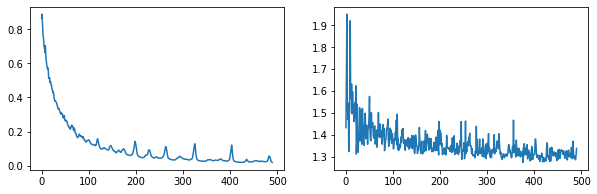

In [10]:
fig, ax = plt.subplots(1,2, figsize=(10,3))

ax[0].plot([itm.cpu().numpy() for itm in train_history[10:]])
ax[1].plot([itm.cpu().numpy() for itm in val_history[10:]])

In [11]:
model.eval()
loss = 0.
for i in np.random.permutation(len(test_data)//batch_size):
    start, end = i*batch_size, (i+1)*batch_size
    x,z = test_data[start:end].cuda(), test_targets[start:end].cuda()
    loss += ((model(x).detach() - z)**2).view(-1,64*64).sum(1).mean()
print('Final Loss: {:2f}'.format(loss/(len(test_data)//batch_size)))

Final Loss: 81.480492


In [12]:
try:
    os.makedirs(f'final-outputs/{savedir}')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

originals = False
try:
    os.makedirs('final-outputs/originals')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise
    originals = True

train_idx = 0
val_idx = 0
test_idx = 0
for i in range(len(data)):
    person, pose = classes[i]
    if (i+1) % 5 != 0: # training data
        prefix = f'train{train_idx}'
        train_idx += 1
    elif (i+1) % 10 == 5: # validation data
        prefix = f'valid{val_idx}'
        val_idx += 1
    else: # (i+1) % 10 == 0 (test data)
        prefix = f'test{test_idx}'
        test_idx += 1
    
    recon = model(data[i].cuda()).detach().cpu().numpy()[0]
    cv2.imwrite(f'final-outputs/{savedir}/{prefix}-person{person}-pose{pose}.png', 255*recon)
    if not originals:
        cv2.imwrite(f'final-outputs/originals/{prefix}-person{person}-pose{pose}.png', 255*targets[i].numpy())

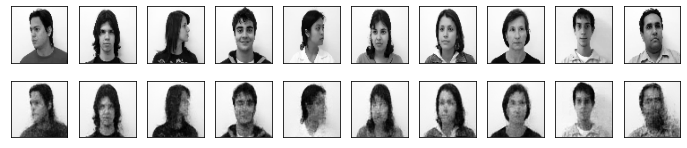

In [13]:
fig, ax = plt.subplots(2,10, figsize=(12,2.5))

model.eval()
reconstructions = model(train_data[0:10].cuda()).detach().cpu()
for i in range(10):
    ax[0,i].imshow(train_targets[i],cmap='Greys_r')
    ax[0,i].set_xticks([]); ax[0,i].set_yticks([])
    
    ax[1,i].imshow(reconstructions[i],cmap='Greys_r')
    ax[1,i].set_xticks([]); ax[1,i].set_yticks([])

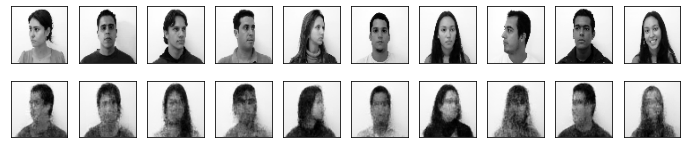

In [14]:
fig, ax = plt.subplots(2,10, figsize=(12,2.5))

model.eval()
reconstructions = model(test_data[0:10].cuda()).detach().cpu()
for i in range(10):    
    ax[0,i].imshow(test_targets[i],cmap='Greys_r')
    ax[0,i].set_xticks([]); ax[0,i].set_yticks([])
    
    ax[1,i].imshow(reconstructions[i],cmap='Greys_r')
    ax[1,i].set_xticks([]); ax[1,i].set_yticks([])